<a href="https://colab.research.google.com/github/Marglodis/challenge2-data-science-LATAM/blob/main/TelecomX_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge Telecom X: Análisis de evasión de clientes

#📌 Extracción

In [84]:
url = 'https://raw.githubusercontent.com/Marglodis/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json'

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
sns.set(style="whitegrid")
%matplotlib inline

In [87]:
# Cargar los datos desde la API
# Cargar directamente como DataFrame
df = pd.read_json(url)

# MOstrar las primeras filas y forma del DataFrame
df
print(df.head())
print(df.shape)

   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   
2  {'InternetService': 'Fiber optic', 'OnlineSecu...   
3  {'I

#🔧 Transformación

In [88]:
# Desanidar el JSON y explorar estructura
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])
df_charges = pd.json_normalize(df['account'].apply(lambda x: x['Charges'] if 'Charges' in x else {}))

cols_to_drop = [col for col in df_account.columns if col.startswith('Charges')]

# Combinar todo en un solo DataFrame
df = pd.concat([
    df[['customerID', 'Churn']],
    df_customer,
    df_phone,
    df_internet,
    df_account.drop(columns=cols_to_drop),
    df_charges
], axis=1)

# Mostrar las primeras filas y forma del DataFrame
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [89]:
# Verificacion de inconsistenicas y limpieza inicial
# VErificacion de duplicados
print("Valores duplicados", df.duplicated().sum())

# VErificar valores nulos
print("\nValores nulos\n", df.isnull().sum())

# Manejar valores vacíos en 'Churn' (reemplazar ' ' con 'No')
df['Churn'] = df['Churn'].replace(' ', 'No')

# Convertir 'Total' de (account.Charges) a float, manejar vacíos
df['Total'] = pd.to_numeric(df['Total'], errors='coerce').fillna(0)

# Renombrar columnas para claridad
df.rename(columns={'Monthly': 'MonthlyCharges', 'Total': 'TotalCharges'}, inplace=True)

# Convertir 'Yes/No' a 1/0 para variables binarias
binary_columns = ['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
               'PaperlessBilling']

for col in binary_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0})

# Manejar categorías inconsistentes (e.g., 'No internet service' ya mapeado a 0 en el paso anterior)

# Mostrar las primeras filas y forma del DataFrame
df.info()
df.head()

Valores duplicados 0

Valores nulos
 customerID          0
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Monthly             0
Total               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   int64  
 5   Dependents        7267 non-null   int64  
 6   

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0002-ORFBO,No,Female,0,1,1,9,1,No,DSL,...,1,0,1,1,0,One year,1,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,0,0,9,1,Yes,DSL,...,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,0,0,4,1,No,Fiber optic,...,0,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,1,0,13,1,No,Fiber optic,...,1,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,1,0,3,1,No,Fiber optic,...,0,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40


In [90]:
# Crear nueva columna Cuentas_Diarias
## Crear columna diaria (aprox. mensual /30) -> Proporciona una vista granular del gasto, útil para patrones temporales en churn.
df['Cuentas_Diarias'] = df['MonthlyCharges'] / 30

# Mostrar las primeras filas y forma del DataFrame
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   int64  
 5   Dependents        7267 non-null   int64  
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   int64  
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   int64  
 11  OnlineBackup      7267 non-null   int64  
 12  DeviceProtection  7267 non-null   int64  
 13  TechSupport       7267 non-null   int64  
 14  StreamingTV       7267 non-null   int64  
 15  StreamingMovies   7267 non-null   int64  
 16  Contract          7267 non-null   object 


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cuentas_Diarias
0,0002-ORFBO,No,Female,0,1,1,9,1,No,DSL,...,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,0,0,0,9,1,Yes,DSL,...,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,0,0,0,4,1,No,Fiber optic,...,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,1,1,0,13,1,No,Fiber optic,...,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,1,1,0,3,1,No,Fiber optic,...,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.796667


#📊 Carga y análisis

In [91]:
# Descriptivo para numéricas
num_desc = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Cuentas_Diarias']].describe()
print(num_desc)

            tenure  MonthlyCharges  TotalCharges  Cuentas_Diarias
count  7267.000000     7267.000000   7267.000000      7267.000000
mean     32.346498       64.720098   2277.182035         2.157337
std      24.571773       30.129572   2268.648587         1.004319
min       0.000000       18.250000      0.000000         0.608333
25%       9.000000       35.425000    396.200000         1.180833
50%      29.000000       70.300000   1389.200000         2.343333
75%      55.000000       89.875000   3778.525000         2.995833
max      72.000000      118.750000   8684.800000         3.958333


In [92]:
# Para categorizar
print(df['gender'].value_counts(normalize=True)) # Proporciones
print(df['SeniorCitizen'].value_counts(normalize=True))
print(df['Partner'].value_counts(normalize=True))
print(df['Dependents'].value_counts(normalize=True))
print(df['PhoneService'].value_counts(normalize=True))
print(df['MultipleLines'].value_counts(normalize=True))
print(df['InternetService'].value_counts(normalize=True))
print(df['OnlineSecurity'].value_counts(normalize=True))
print(df['OnlineBackup'].value_counts(normalize=True))
print(df['DeviceProtection'].value_counts(normalize=True))
print(df['TechSupport'].value_counts(normalize=True))
print(df['StreamingTV'].value_counts(normalize=True))
print(df['StreamingMovies'].value_counts(normalize=True))
print(df['Contract'].value_counts(normalize=True))
print(df['PaperlessBilling'].value_counts(normalize=True))
print(df['PaymentMethod'].value_counts(normalize=True))
print(df['Churn'].value_counts(normalize=True))


gender
Male      0.505711
Female    0.494289
Name: proportion, dtype: float64
SeniorCitizen
0    0.837347
1    0.162653
Name: proportion, dtype: float64
Partner
0    0.515894
1    0.484106
Name: proportion, dtype: float64
Dependents
0    0.699876
1    0.300124
Name: proportion, dtype: float64
PhoneService
1    0.902711
0    0.097289
Name: proportion, dtype: float64
MultipleLines
No                  0.480941
Yes                 0.421770
No phone service    0.097289
Name: proportion, dtype: float64
InternetService
Fiber optic    0.440072
DSL            0.342370
No             0.217559
Name: proportion, dtype: float64
OnlineSecurity
0    0.71405
1    0.28595
Name: proportion, dtype: float64
OnlineBackup
0    0.655429
1    0.344571
Name: proportion, dtype: float64
DeviceProtection
0    0.657218
1    0.342782
Name: proportion, dtype: float64
TechSupport
0    0.710472
1    0.289528
Name: proportion, dtype: float64
StreamingTV
0    0.616073
1    0.383927
Name: proportion, dtype: float64
Strea

In [93]:
# Distribución de Evasión (Churn) Visualizar la tasa de churn (~26% Yes), identificando el desbalance.
# Proporción de CHurn
churn_dist = df['Churn'].value_counts(normalize=True) * 100
print(churn_dist)
print(df['Contract'].value_counts(normalize=True) * 100)
print(df['PaymentMethod'].value_counts(normalize=True) * 100)
print(df['gender'].value_counts(normalize=True) * 100)

Churn
No     71.198569
Yes    25.719004
        3.082427
Name: proportion, dtype: float64
Contract
Month-to-month    55.112151
Two year          23.985138
One year          20.902711
Name: proportion, dtype: float64
PaymentMethod
Electronic check             33.645246
Mailed check                 22.911793
Bank transfer (automatic)    21.865969
Credit card (automatic)      21.576992
Name: proportion, dtype: float64
gender
Male      50.571075
Female    49.428925
Name: proportion, dtype: float64


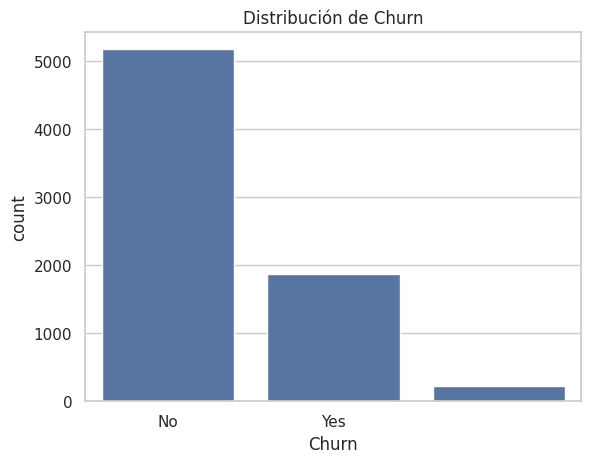

In [94]:
# Gráfico
sns.countplot(x='Churn', data=df)
plt.title('Distribución de Churn')
plt.show()

gender
Female    26.141425
Male      25.306122
Name: Yes, dtype: float64
SeniorCitizen
0    22.892358
1    40.270728
Name: Yes, dtype: float64
Partner
0    32.008536
1    19.016487
Name: Yes, dtype: float64
Dependents
0    30.338183
1    14.947272
Name: Yes, dtype: float64
PhoneService
0    24.045262
1    25.899390
Name: Yes, dtype: float64


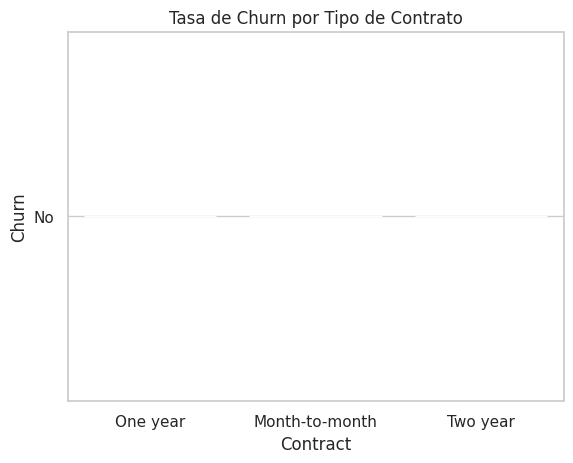

In [95]:
# Recuento de evasión por variables categóricas
# funcion para churn rate (tasa de abandono) por categoría (Revelar patrones (e.g., alto churn en 'Month-to-month') para insights estratégicos.)
def churn_rate_by_category(col):
  return df.groupby(col)['Churn'].value_counts(normalize=True).unstack().fillna(0)['Yes'] * 100

print(churn_rate_by_category('gender'))
print(churn_rate_by_category('SeniorCitizen'))
print(churn_rate_by_category('Partner'))
print(churn_rate_by_category('Dependents'))
print(churn_rate_by_category('PhoneService'))

    # Gráfico
sns.barplot(x='Contract', y='Churn', data=df, estimator=lambda x: sum(x=='Yes')/len(x)*100)
plt.title('Tasa de Churn por Tipo de Contrato')
plt.show()

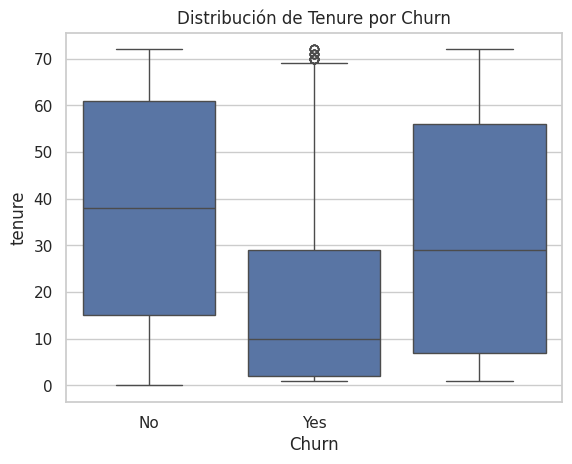

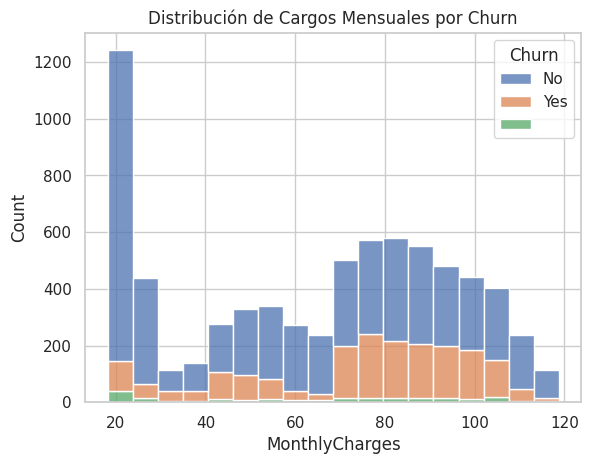

In [96]:
# COnteo de evasión para variables numéricas
## sns.boxplot() muestra mediana/outliers. sns.histplot(hue='Churn') compara distribuciones.
## Propósito: Identificar diferencias (e.g., bajo tenure en churn Yes).
# BoxPlot
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Distribución de Tenure por Churn')
plt.show()

# Histograma
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack')
plt.title('Distribución de Cargos Mensuales por Churn')
plt.show()

#📄Informe final